In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [2]:
file_name = 'pre_processado_completo.csv'

df = pd.read_csv(file_name, header=0, error_bad_lines=False, warn_bad_lines=False, low_memory=False)

In [3]:
df.head()

,city,state,country,shape,duration_m,comments,latitude,longitude,date
0,san marcos,tx,us,cylinder,45.000000,This event took place in early fall around 194...,29.883056,-97.941111,1949-10-10
1,lackland afb,tx,NaN,light,120.000000,1949 Lackland AFB&#44 TX. Lights racing acros...,29.384210,-98.581082,1949-10-10
2,chester (uk/england),NaN,gb,circle,0.333333,Green/Orange circular disc over Chester&#44 En...,53.200000,-2.916667,1955-10-10
3,edna,tx,us,circle,0.333333,My older brother and twin sister were leaving ...,28.978333,-96.645833,1956-10-10
4,kaneohe,hi,us,light,15.000000,AS a Marine 1st Lt. flying an FJ4B fighter/att...,21.418056,-157.803611,1960-10-10


In [4]:
# define um array com as latitudes e longitudes

lat_lon = np.array(df[['longitude', 'latitude']]).astype(float)
print(len(lat_lon))
print(lat_lon)

88673
[[-97.9411111  29.8830556]
 [-98.581082   29.38421  ]
 [ -2.916667   53.2      ]
 ...
 [-97.4777778  35.6527778]
 [-82.6958333  34.3769444]
 [-80.1436111  26.1219444]]


In [ ]:
# define uma lista com os estados, e calcula o peso de cada estado de acordo com a quantidade de avistamentos, pelo método count

states = list(df['state'])
pesos = [states.count(s) for s in states]

In [ ]:
scaler = MinMaxScaler()

In [ ]:
# aplica o elbow criteria

sse = {}
for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(scaler.fit_transform(lat_lon), sample_weight=pesos)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

### De acordo com o Elbow Criteria o número adequado de clusters é em torno de 25

In [41]:
# aplica o algoritmo kmeans, utilizando os pesos e normalizando os valores

kmeans = KMeans(n_clusters=25, max_iter=2000)
kmeans.fit(scaler.fit_transform(lat_lon), sample_weight=pesos)
lat_lon_scaled = np.array(scaler.fit_transform(lat_lon))
lat_lon_scaled

array([[0.22167546, 0.72476095],
       [0.21987323, 0.72155423],
       [0.4892746 , 0.87464866],
       ...,
       [0.22298025, 0.7618503 ],
       [0.26460781, 0.7536489 ],
       [0.27179515, 0.70058349]])

In [42]:
centers = kmeans.cluster_centers_
centers

In [43]:
locations = kmeans.labels_.astype(float)
print(len(locations))
locations

88673


array([0., 0., 3., ..., 0., 0., 0.])

Text(0, 0.5, 'Longitude')

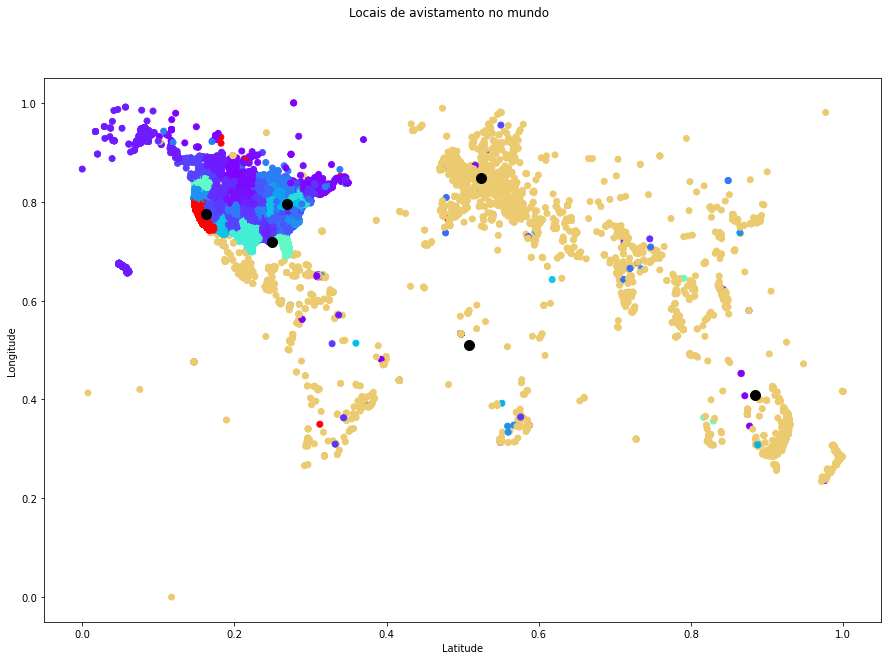

In [47]:
fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(lat_lon_scaled[:, 0], lat_lon_scaled[:, 1], c=pesos, cmap='rainbow')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=100)
fig.suptitle('Locais de avistamento no mundo')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

In [ ]:
geolocator = Nominatim(user_agent="geoapiExercises")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [ ]:
centers_notscaled = scaler.inverse_transform(centers)
df_centers_notscaled = pd.DataFrame(centers_notscaled, columns=['lon', 'lat'])
df_centers_notscaled

In [ ]:
centers_notscaled = df_centers[['lat', 'lon']]
centers_notscaled = centers_notscaled.to_records(index=False)
centers_notscaled = list(centers_notscaled)

In [ ]:
locations = [reverse(loc) for loc in centers_notscaled if loc]

In [ ]:
df_locations = pd.DataFrame(locations)
df_locations.rename(columns={0:'Endereço', 1:'Latitude e Longitude'}, inplace=True)
df_locations